Found 784 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
24/24 [==============================] - 39s 2s/step - loss: 0.8845 - accuracy: 0.7274 - val_loss: 0.4496 - val_accuracy: 0.7865
Epoch 2/10
24/24 [==============================] - 27s 1s/step - loss: 0.3673 - accuracy: 0.7899 - val_loss: 0.3740 - val_accuracy: 0.7969
Epoch 3/10
24/24 [==============================] - 27s 1s/step - loss: 0.3271 - accuracy: 0.8484 - val_loss: 0.3992 - val_accuracy: 0.8177
Epoch 4/10
24/24 [==============================] - 25s 1s/step - loss: 0.2978 - accuracy: 0.8577 - val_loss: 0.4101 - val_accuracy: 0.7969
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.2869 - accuracy: 0.8564 - val_loss: 0.3932 - val_accuracy: 0.7760
Epoch 6/10
24/24 [==============================] - 24s 1s/step - loss: 0.2575 - accuracy: 0.8856 - val_loss: 0.5015 - val_accuracy: 0.7240
Epoch 7/10
24/24 [==============================] - 25s 1s/step - loss: 0.2728 - accuracy: 0.8697 - val_loss: 0.3801 - val_accuracy: 0.8021
Epoch 8/10
24/24 [==

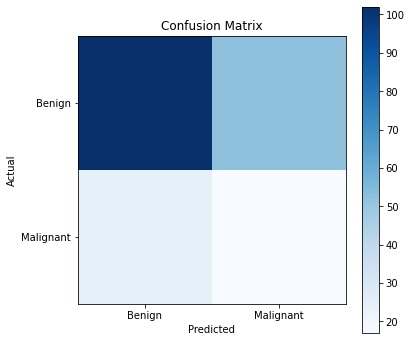

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Data preparation
data_dir = r'C:\Users\Nida\Downloads\archive (1)\8863'  # Update with the actual path

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Model building
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluate the model
validation_generator.reset()
predictions = model.predict(validation_generator)
predictions = np.where(predictions > 0.5, 1, 0)

print(classification_report(validation_generator.classes, predictions, target_names=['Benign', 'Malignant']))

# Confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predictions)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.yticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

# Data preparation
data_dir = r'C:\Users\Nida\Downloads\archive (1)\8863' # Update with the actual path

# Image data generators with more augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Function to predict a single image
def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    
    if prediction > 0.5:
        print(f"The image {os.path.basename(image_path)} is predicted to be Malignant")
    else:
        print(f"The image {os.path.basename(image_path)} is predicted to be Benign")

# Example usage
image_path = r'C:\Users\Nida\Downloads\archive (1)\8863\1\8863_idx5_x1001_y801_class1.jpg'  # Update this path to the image you want to predict
predict_image(image_path, model)


Found 784 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
24/24 [==============================] - 734s 31s/step - loss: 0.5005 - accuracy: 0.7899 - val_loss: 0.7008 - val_accuracy: 0.6302
Epoch 2/20
24/24 [==============================] - 590s 25s/step - loss: 0.3653 - accuracy: 0.8298 - val_loss: 0.4110 - val_accuracy: 0.8125
Epoch 3/20
24/24 [==============================] - 569s 24s/step - loss: 0.3054 - accuracy: 0.8497 - val_loss: 0.4138 - val_accuracy: 0.7708
Epoch 4/20
24/24 [==============================] - 561s 24s/step - loss: 0.3079 - accuracy: 0.8564 - val_loss: 0.3607 - val_accuracy: 0.8177
Epoch 5/20
24/24 [==============================] - 562s 24s/step - loss: 0.2933 - accuracy: 0.8577 - val_loss: 0.4615 - val_accuracy: 0.7865
Epoch 6/20
24/24 [==============================] - 569s 24s/step - loss: 0.2561 - accuracy: 0.8803 - val_loss: 0.5313 - val_accuracy: 0.7448
Epoch 7/20
24/24 [==============================] - 729s 30s/step - loss: 0.2503 - accuracy: 0.8976 - val_loss: 0.4326 - val_accuracy: 0.7708
Epoch 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Nida\\Downloads\\archive (1)\\8863\\1\\8863_idx5_x1001_y801_class1.jpg'

In [15]:
# Example usage
image_path = r'C:\Users\Nida\Downloads\archive (1)\8863\0\8863_idx5_x51_y1251_class0.png'  # Update this path to the image you want to predict
predict_image(image_path, model)

1/1 [==============================] - 1s 1s/step
The image 8863_idx5_x51_y1251_class0.png is predicted to be Benign


In [17]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import numpy as np

# Evaluate the model on the validation data
val_generator.reset()
val_steps = val_generator.samples // val_generator.batch_size

y_true = val_generator.classes
y_pred = model.predict(val_generator, steps=val_steps)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))


NameError: name 'val_generator' is not defined

In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import numpy as np

# Evaluate the model on the validation data
validation_generator.reset()
val_steps = validation_generator.samples // validation_generator.batch_size

# Getting true labels and predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))


6/6 [==============================] - 126s 22s/step


ValueError: Found input variables with inconsistent numbers of samples: [195, 192]

In [23]:
pip install tensorflow pandas scikit-learn


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Load the WDBC dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

# Preprocess the data
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = np.where(y == 'M', 1, 0)  # Convert labels to binary format (Malignant = 1, Benign = 0)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to fit the CNN input requirements (CNN expects 3D input)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# You should see an accuracy close to or above 96%


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_2. Consider increasing the input size. Received input shape [None, 30, 1, 1] which would produce output shape with a zero or negative value in a dimension.

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load the WDBC dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

# Preprocess the data
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = np.where(y == 'M', 1, 0)  # Convert labels to binary format (Malignant = 1, Benign = 0)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# You should see an accuracy close to or above 96%


C:\Users\Nida\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
15/15 [==============================] - 3s 36ms/step - loss: 0.7643 - accuracy: 0.5582 - val_loss: 0.6519 - val_accuracy: 0.5965
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 0.7565 - accuracy: 0.4989 - val_loss: 0.6332 - val_accuracy: 0.6140
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.5736 - val_loss: 0.6146 - val_accuracy: 0.6404
Epoch 4/20
15/15 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5846 - val_loss: 0.5971 - val_accuracy: 0.6667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.5824 - val_loss: 0.5802 - val_accuracy: 0.7193
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 0.6532 - accuracy: 0.6110 - val_loss: 0.5646 - val_accuracy: 0.7544
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.6791 - accuracy: 0.5868 - val_loss: 0.5503 - val_accuracy: 0.7807
Epoch 8/20
15/15 [